# Conjugate Gradient Methods for Portfolio Optimization
## Visualization and Analysis Notebook

This notebook provides comprehensive visualizations of:
1. **Data Properties** - Asset returns, correlations, covariance conditioning
2. **Solver Convergence** - Iteration counts, residual decay
3. **Numerical Diagnostics** - Error distributions, runtime analysis
4. **Backtest Performance** - Cumulative returns, drawdowns, comparisons


In [3]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [4]:
# Import libraries and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Custom color palette for solvers
SOLVER_COLORS = {
    'GD': '#e74c3c',
    'CG': '#3498db',
    'PCG_Jacobi': '#2ecc71',
    'PCG_SSOR': '#9b59b6',
    'PCG_IChol': '#f39c12',
    'SPY': '#7f8c8d'
}

# Data directory
DATA_DIR = 'data'

# Create figures directory
os.makedirs(f'{DATA_DIR}/figures', exist_ok=True)

print('Libraries loaded successfully!')


Libraries loaded successfully!


In [5]:
# Load all data
print('Loading data...')

# Raw data
returns = pd.read_csv(f'{DATA_DIR}/semiconductor_returns.csv', index_col='Date', parse_dates=True)
prices = pd.read_csv(f'{DATA_DIR}/semiconductor_prices.csv', index_col='Date', parse_dates=True)
train_returns = pd.read_csv(f'{DATA_DIR}/train_returns.csv', index_col='Date', parse_dates=True)
test_returns = pd.read_csv(f'{DATA_DIR}/test_returns.csv', index_col='Date', parse_dates=True)

# Covariance and schedule
cov_matrix = pd.read_csv(f'{DATA_DIR}/covariance_matrix.csv', index_col=0)
schedule = pd.read_csv(f'{DATA_DIR}/rebalancing_schedule.csv')
schedule['rebal_date'] = pd.to_datetime(schedule['rebal_date'])

# Numerical diagnostics
diagnostics = pd.read_csv(f'{DATA_DIR}/numerical_diagnostics/all_diagnostics.csv')
diag_summary = pd.read_csv(f'{DATA_DIR}/numerical_diagnostics/summary.csv')

# Backtest results
portfolio_returns = pd.read_csv(f'{DATA_DIR}/backtest_results/portfolio_returns.csv', index_col='Date', parse_dates=True)
cumulative_returns = pd.read_csv(f'{DATA_DIR}/backtest_results/cumulative_returns.csv', index_col='Date', parse_dates=True)
performance_metrics = pd.read_csv(f'{DATA_DIR}/backtest_results/performance_metrics.csv')
weight_divergence = pd.read_csv(f'{DATA_DIR}/backtest_results/weight_divergence.csv')

# Solver list
SOLVERS = ['GD', 'CG', 'PCG_Jacobi', 'PCG_SSOR', 'PCG_IChol']

print('Data loaded successfully!')
print(f'Assets: {len(returns.columns)}, Days: {len(returns)}')


Loading data...
Data loaded successfully!
Assets: 19, Days: 1759


---
# Section 1: Data Properties


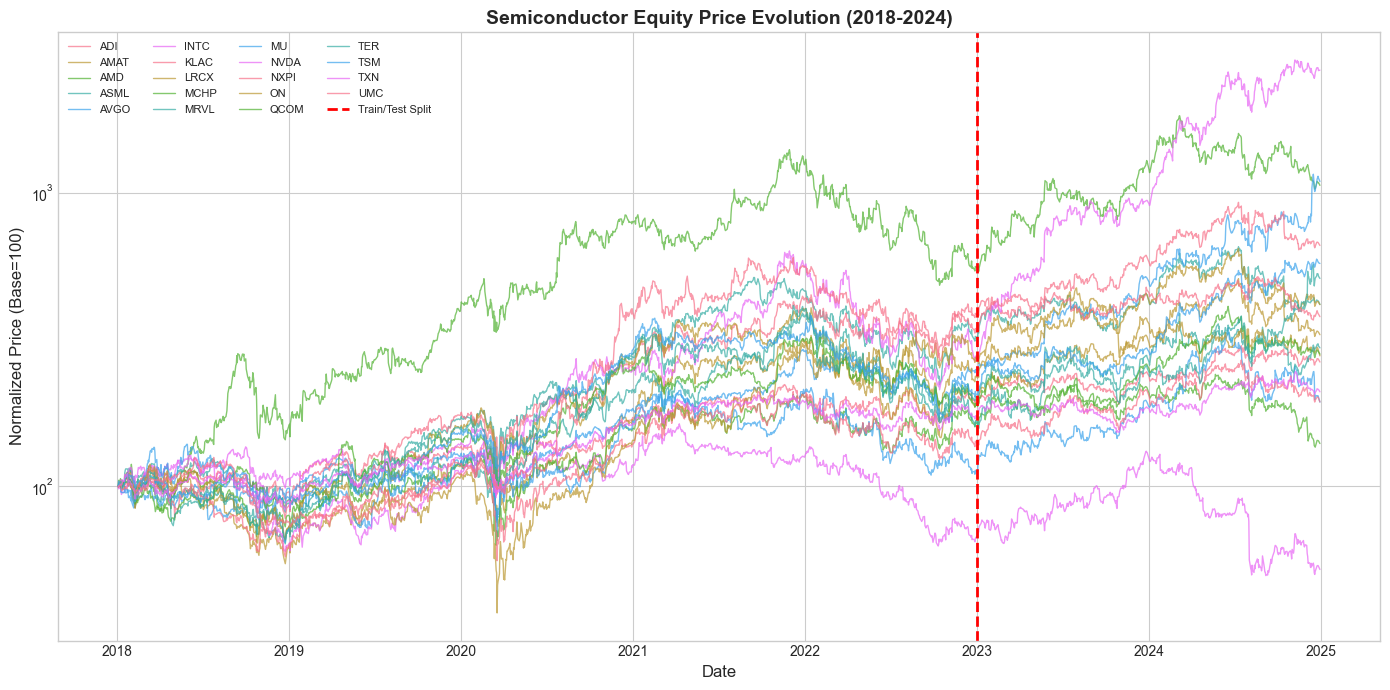

In [6]:
# 1.1 Price Evolution
fig, ax = plt.subplots(figsize=(14, 7))

# Normalize prices to start at 100
normalized_prices = prices / prices.iloc[0] * 100

for col in normalized_prices.columns:
    ax.plot(normalized_prices.index, normalized_prices[col], alpha=0.7, linewidth=1, label=col)

ax.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Price (Base=100)', fontsize=12)
ax.set_title('Semiconductor Equity Price Evolution (2018-2024)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', ncol=4, fontsize=8)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/price_evolution.png', dpi=150, bbox_inches='tight')
plt.show()


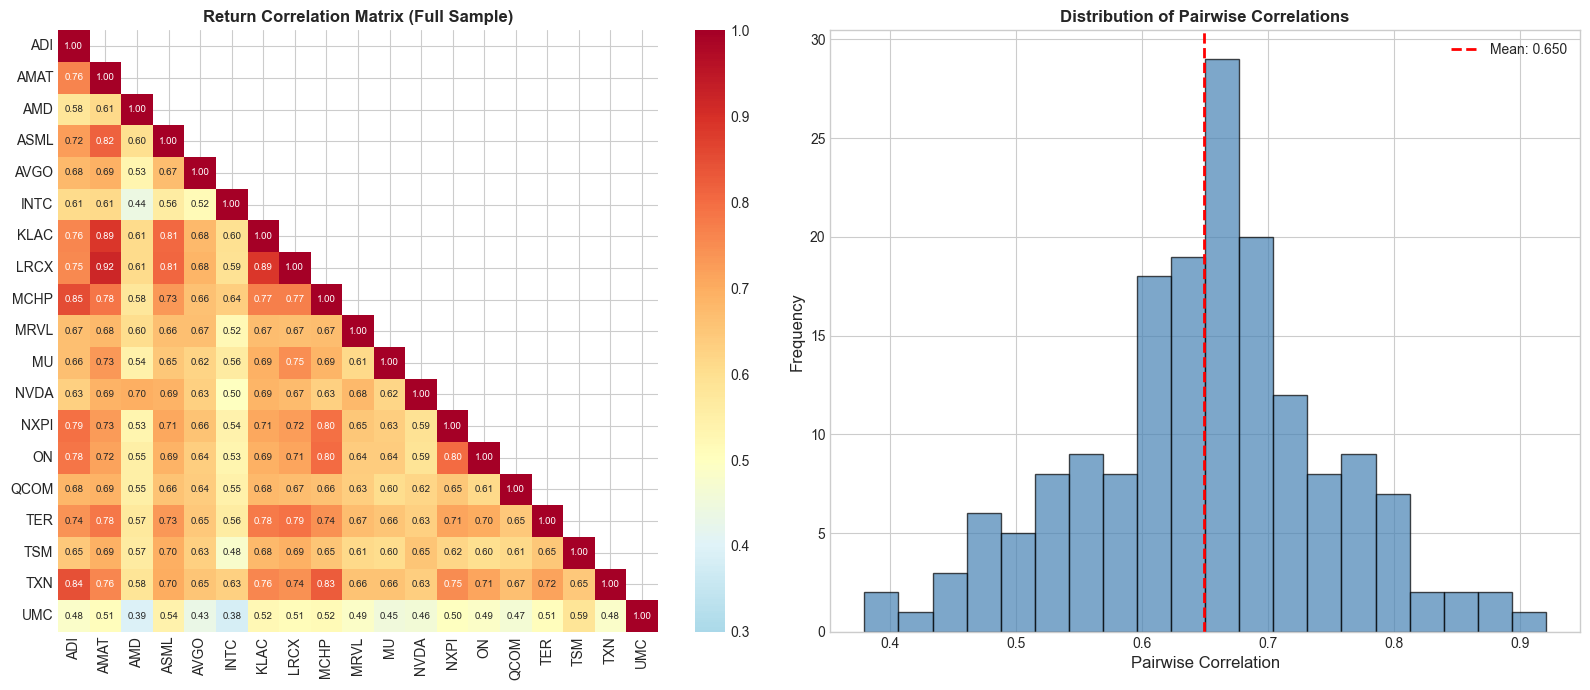

In [7]:
# 1.2 Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Full sample correlation
corr_full = returns.corr()
mask = np.triu(np.ones_like(corr_full, dtype=bool), k=1)

sns.heatmap(corr_full, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0.5, vmin=0.3, vmax=1, ax=axes[0], annot_kws={'size': 7})
axes[0].set_title('Return Correlation Matrix (Full Sample)', fontsize=12, fontweight='bold')

# Correlation distribution
upper_tri = corr_full.values[np.triu_indices_from(corr_full.values, k=1)]
axes[1].hist(upper_tri, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(upper_tri.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {upper_tri.mean():.3f}')
axes[1].set_xlabel('Pairwise Correlation', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Pairwise Correlations', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


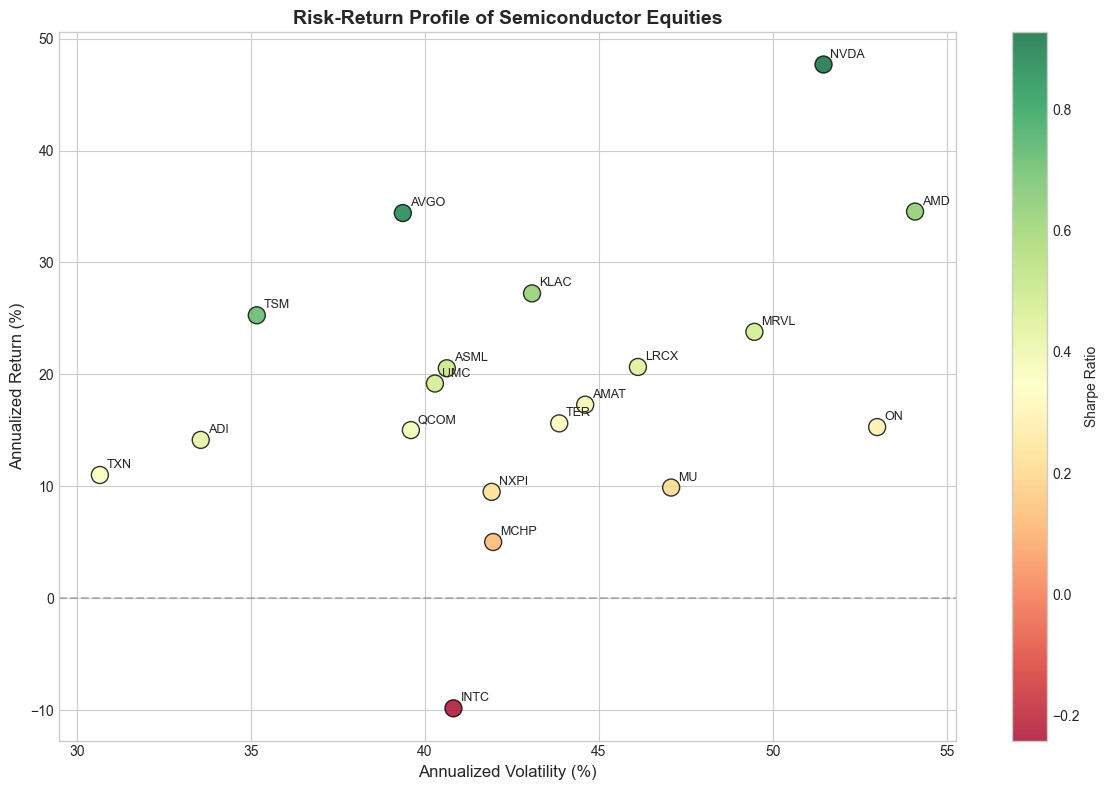

In [8]:
# 1.3 Risk-Return Scatter Plot
fig, ax = plt.subplots(figsize=(12, 8))

ann_returns = returns.mean() * 252 * 100
ann_vol = returns.std() * np.sqrt(252) * 100
sharpe = ann_returns / ann_vol

scatter = ax.scatter(ann_vol, ann_returns, c=sharpe, cmap='RdYlGn', s=150, edgecolor='black', alpha=0.8)
plt.colorbar(scatter, label='Sharpe Ratio')

for ticker in returns.columns:
    ax.annotate(ticker, (ann_vol[ticker], ann_returns[ticker]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax.set_ylabel('Annualized Return (%)', fontsize=12)
ax.set_title('Risk-Return Profile of Semiconductor Equities', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/risk_return_scatter.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 2: Solver Convergence Behavior


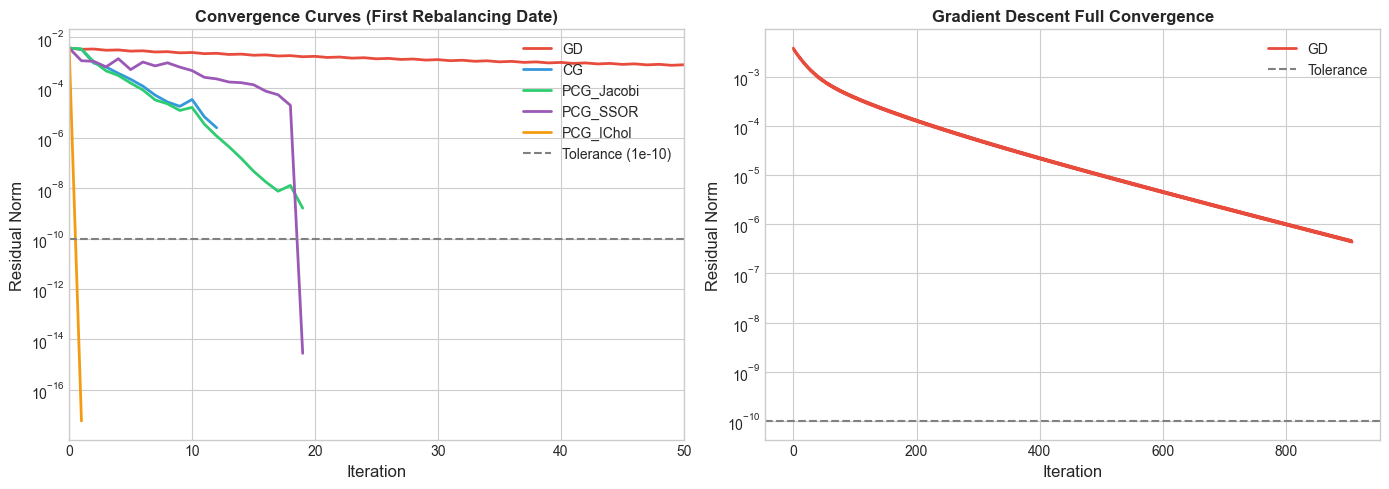

In [9]:
# 2.1 Convergence Curves (Single Date Example)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Load convergence data for first rebalancing date
for solver in SOLVERS:
    conv_df = pd.read_csv(f'{DATA_DIR}/optimization_results/convergence/convergence_{solver}.csv', index_col=0)
    first_col = conv_df.columns[0]
    data = conv_df[first_col].dropna().values
    axes[0].semilogy(range(len(data)), data, label=solver, color=SOLVER_COLORS[solver], linewidth=2)

axes[0].axhline(1e-10, color='gray', linestyle='--', label='Tolerance (1e-10)')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Residual Norm', fontsize=12)
axes[0].set_title('Convergence Curves (First Rebalancing Date)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].set_xlim(0, 50)

# Full view for GD
conv_gd = pd.read_csv(f'{DATA_DIR}/optimization_results/convergence/convergence_GD.csv', index_col=0)
gd_data = conv_gd[conv_gd.columns[0]].dropna().values
axes[1].semilogy(range(len(gd_data)), gd_data, color=SOLVER_COLORS['GD'], linewidth=2, label='GD')
axes[1].axhline(1e-10, color='gray', linestyle='--', label='Tolerance')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Residual Norm', fontsize=12)
axes[1].set_title('Gradient Descent Full Convergence', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/convergence_curves.png', dpi=150, bbox_inches='tight')
plt.show()


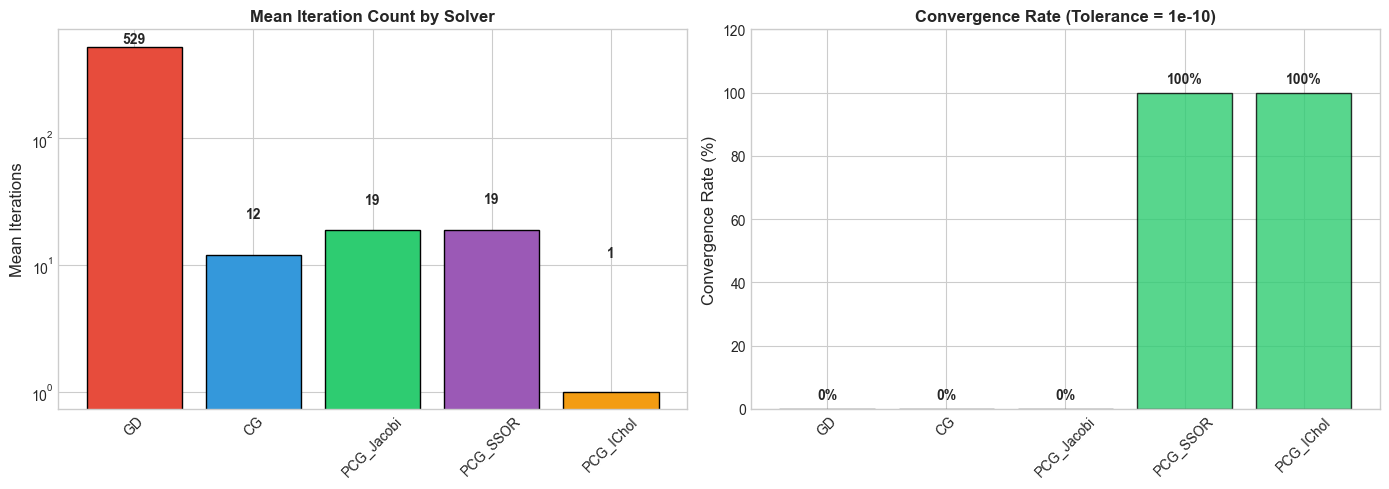

In [10]:
# 2.2 Iteration Count and Convergence Rate Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean iterations bar chart
mean_iters = [diagnostics[diagnostics['solver'] == s]['iterations'].mean() for s in SOLVERS]
bars = axes[0].bar(SOLVERS, mean_iters, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')

for bar, val in zip(bars, mean_iters):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 f'{val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[0].set_ylabel('Mean Iterations', fontsize=12)
axes[0].set_title('Mean Iteration Count by Solver', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)

# Convergence rate
conv_rates = [diag_summary[diag_summary['solver'] == s]['convergence_rate'].values[0] * 100 for s in SOLVERS]
colors = ['#2ecc71' if r == 100 else '#e74c3c' for r in conv_rates]
bars = axes[1].bar(SOLVERS, conv_rates, color=colors, edgecolor='black', alpha=0.8)

for bar, val in zip(bars, conv_rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_ylabel('Convergence Rate (%)', fontsize=12)
axes[1].set_title('Convergence Rate (Tolerance = 1e-10)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 120)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/iteration_convergence.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 3: Numerical Diagnostics


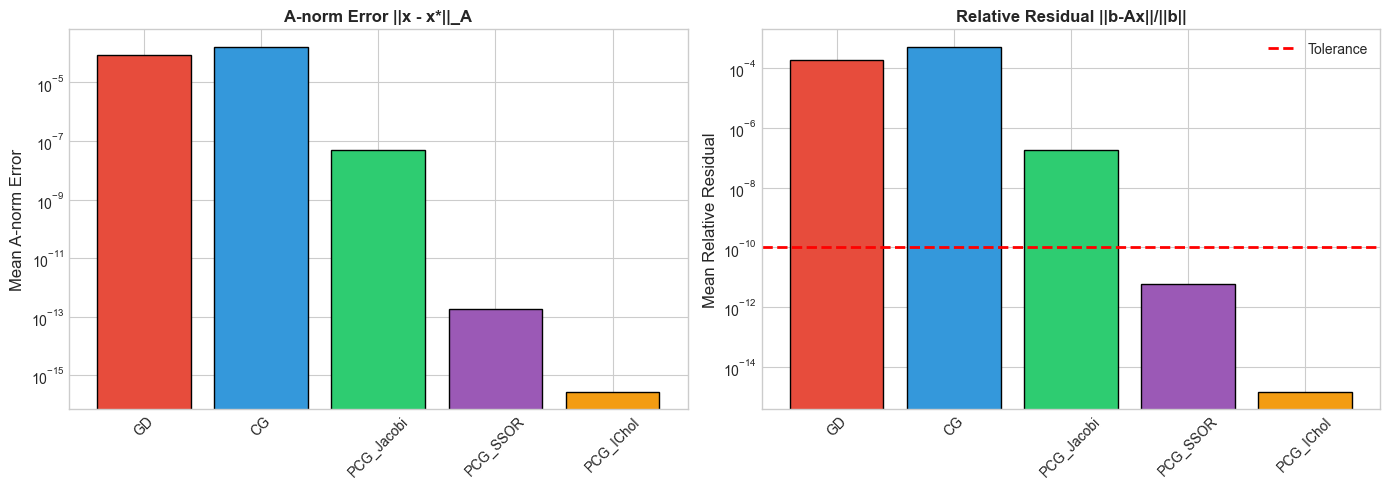

In [11]:
# 3.1 A-norm Error and Relative Residual Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A-norm error
mean_errors = [diagnostics[diagnostics['solver'] == s]['a_norm_error'].mean() for s in SOLVERS]
bars = axes[0].bar(SOLVERS, mean_errors, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
axes[0].set_ylabel('Mean A-norm Error', fontsize=12)
axes[0].set_title('A-norm Error ||x - x*||_A', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)

# Relative residual
mean_residuals = [diagnostics[diagnostics['solver'] == s]['relative_residual'].mean() for s in SOLVERS]
bars = axes[1].bar(SOLVERS, mean_residuals, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
axes[1].axhline(1e-10, color='red', linestyle='--', linewidth=2, label='Tolerance')
axes[1].set_ylabel('Mean Relative Residual', fontsize=12)
axes[1].set_title('Relative Residual ||b-Ax||/||b||', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/numerical_errors.png', dpi=150, bbox_inches='tight')
plt.show()


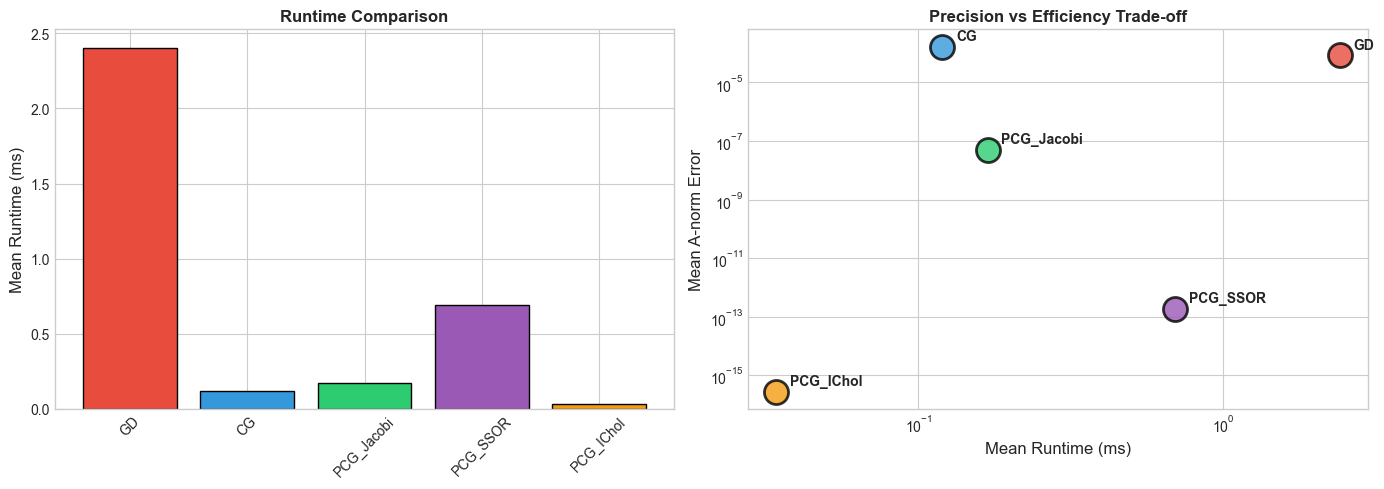

In [12]:
# 3.2 Runtime and Precision-Efficiency Trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Runtime comparison
mean_times = [diagnostics[diagnostics['solver'] == s]['wall_clock_time_ms'].mean() for s in SOLVERS]
bars = axes[0].bar(SOLVERS, mean_times, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
axes[0].set_ylabel('Mean Runtime (ms)', fontsize=12)
axes[0].set_title('Runtime Comparison', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Precision vs Efficiency scatter
for solver in SOLVERS:
    sdf = diagnostics[diagnostics['solver'] == solver]
    mean_time = sdf['wall_clock_time_ms'].mean()
    mean_error = sdf['a_norm_error'].mean()
    axes[1].scatter(mean_time, mean_error, s=300, c=SOLVER_COLORS[solver], 
                    edgecolor='black', linewidth=2, label=solver, alpha=0.8)
    axes[1].annotate(solver, (mean_time, mean_error), xytext=(10, 5), 
                     textcoords='offset points', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Mean Runtime (ms)', fontsize=12)
axes[1].set_ylabel('Mean A-norm Error', fontsize=12)
axes[1].set_title('Precision vs Efficiency Trade-off', fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/precision_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 4: Backtest Performance


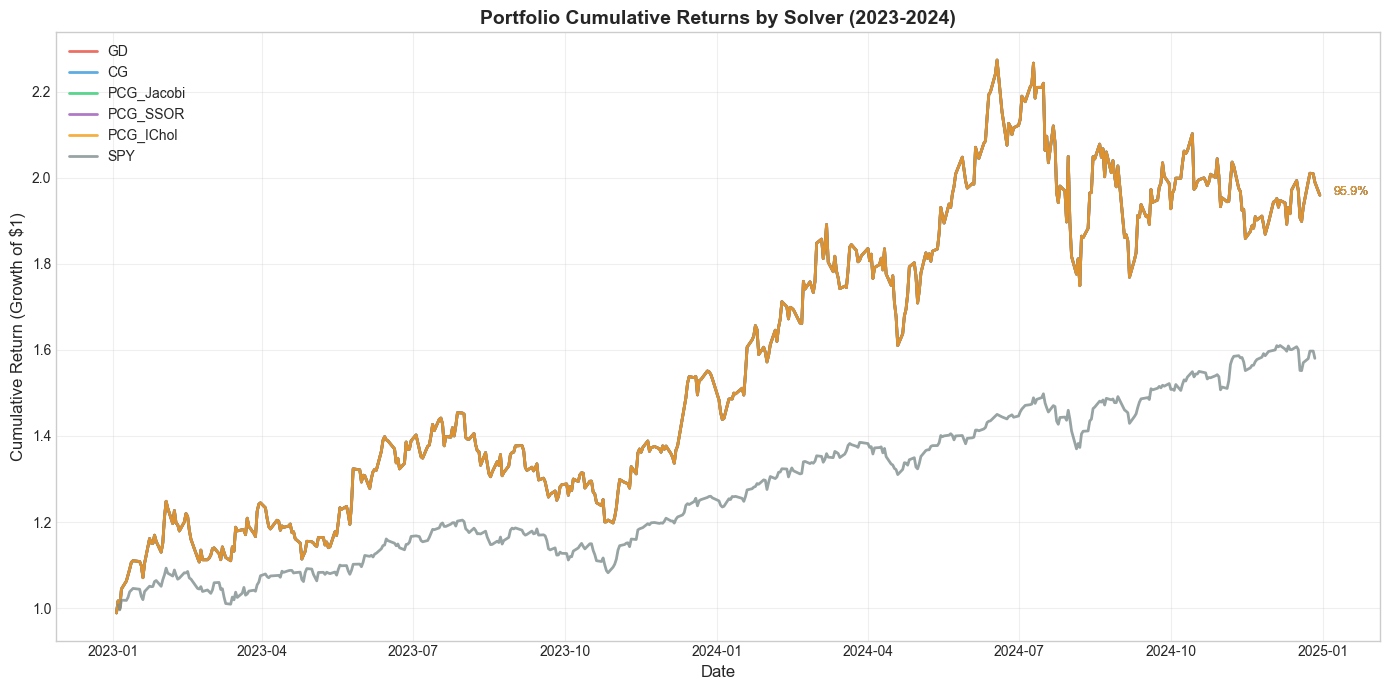

In [13]:
# 4.1 Cumulative Returns Comparison
fig, ax = plt.subplots(figsize=(14, 7))

for col in cumulative_returns.columns:
    if col in SOLVER_COLORS:
        ax.plot(cumulative_returns.index, cumulative_returns[col], 
                label=col, color=SOLVER_COLORS[col], linewidth=2, alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (Growth of $1)', fontsize=12)
ax.set_title('Portfolio Cumulative Returns by Solver (2023-2024)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Add final values annotation
for col in SOLVERS:
    if col in cumulative_returns.columns:
        final_val = cumulative_returns[col].iloc[-1]
        ax.annotate(f'{(final_val-1)*100:.1f}%', 
                    xy=(cumulative_returns.index[-1], final_val),
                    xytext=(10, 0), textcoords='offset points',
                    fontsize=9, color=SOLVER_COLORS[col])

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/cumulative_returns.png', dpi=150, bbox_inches='tight')
plt.show()


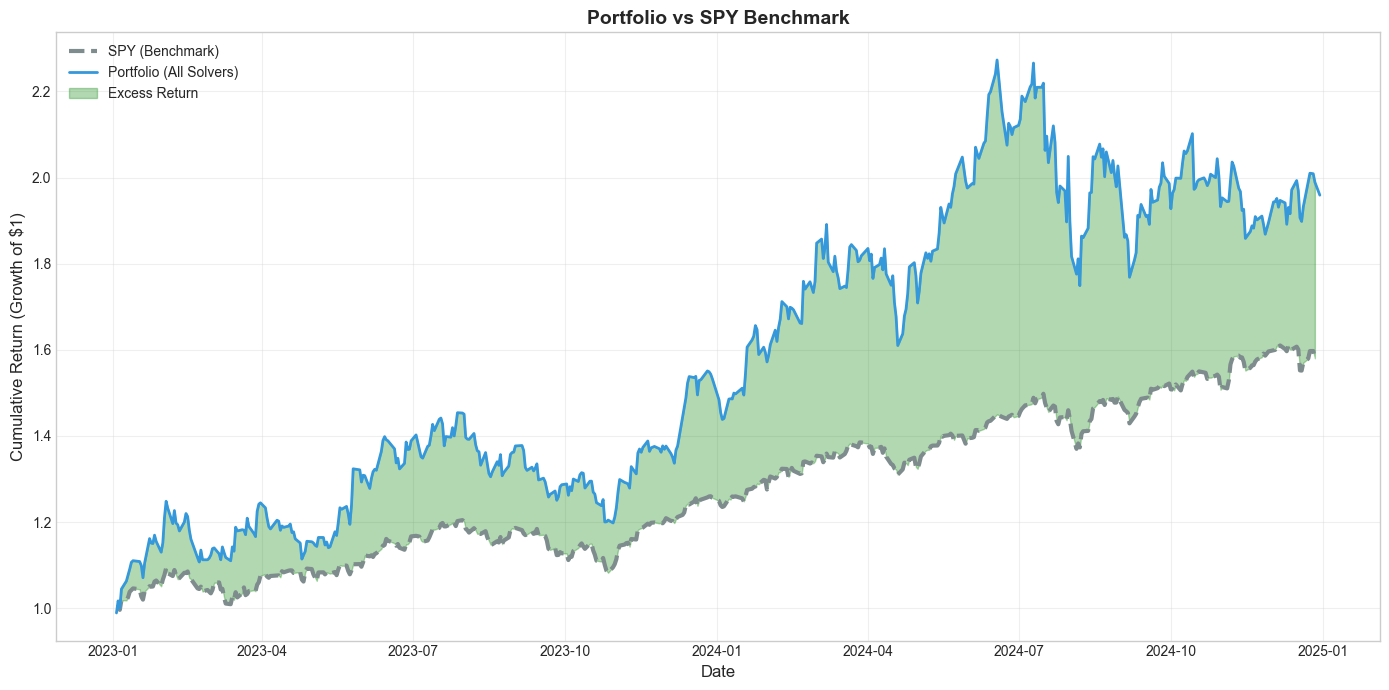

In [14]:
# 4.2 Portfolio vs Benchmark
fig, ax = plt.subplots(figsize=(14, 7))

# Plot benchmark
if 'SPY' in cumulative_returns.columns:
    ax.plot(cumulative_returns.index, cumulative_returns['SPY'], 
            label='SPY (Benchmark)', color=SOLVER_COLORS['SPY'], linewidth=3, linestyle='--')

# Plot one solver (they're all essentially the same)
ax.plot(cumulative_returns.index, cumulative_returns['PCG_IChol'], 
        label='Portfolio (All Solvers)', color='#3498db', linewidth=2)

# Fill between for excess return
if 'SPY' in cumulative_returns.columns:
    ax.fill_between(cumulative_returns.index, 
                    cumulative_returns['SPY'], 
                    cumulative_returns['PCG_IChol'],
                    alpha=0.3, color='green', label='Excess Return')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (Growth of $1)', fontsize=12)
ax.set_title('Portfolio vs SPY Benchmark', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/portfolio_vs_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()


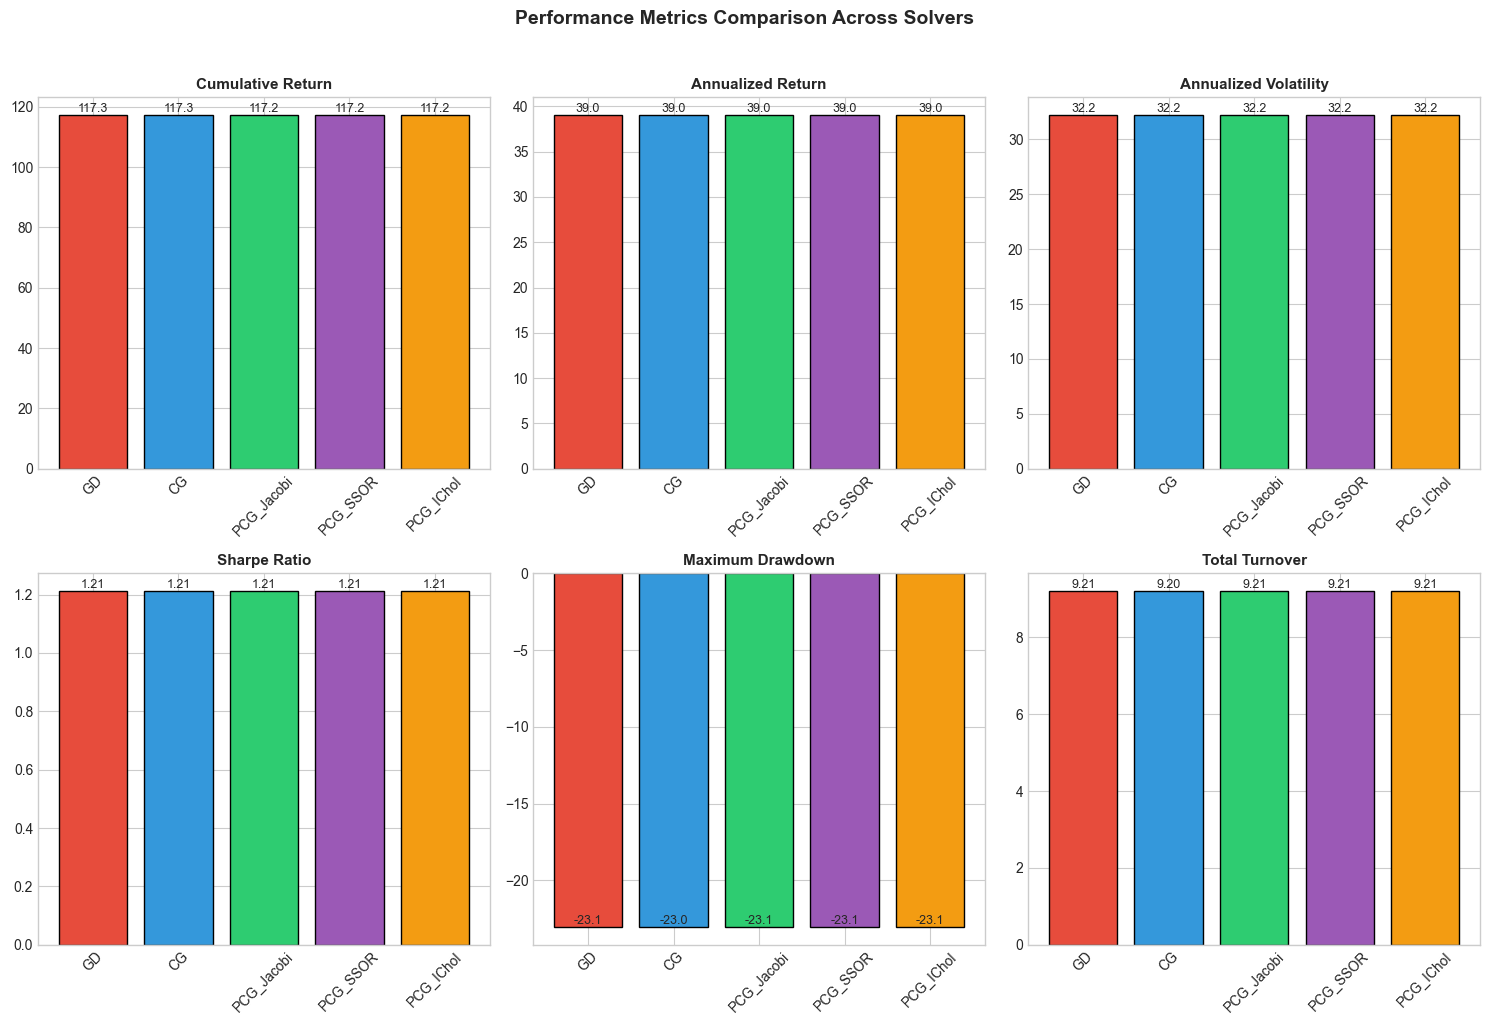

In [15]:
# 4.3 Performance Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = [
    ('Cumulative Return (%)', 'Cumulative Return'),
    ('Annualized Return (%)', 'Annualized Return'),
    ('Annualized Volatility (%)', 'Annualized Volatility'),
    ('Sharpe Ratio', 'Sharpe Ratio'),
    ('Max Drawdown (%)', 'Maximum Drawdown'),
    ('Total Turnover', 'Total Turnover')
]

solver_metrics = performance_metrics[performance_metrics['Solver'].isin(SOLVERS)]

for ax, (col, title) in zip(axes.flatten(), metrics_to_plot):
    values = solver_metrics[col].values
    colors_list = [SOLVER_COLORS[s] for s in solver_metrics['Solver']]
    
    bars = ax.bar(solver_metrics['Solver'], values, color=colors_list, edgecolor='black')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, values):
        fmt = '.2f' if 'Sharpe' in col or 'Turnover' in col else '.1f'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{val:{fmt}}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Performance Metrics Comparison Across Solvers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/figures/performance_metrics.png', dpi=150, bbox_inches='tight')
plt.show()


---
# Section 5: Summary Dashboard


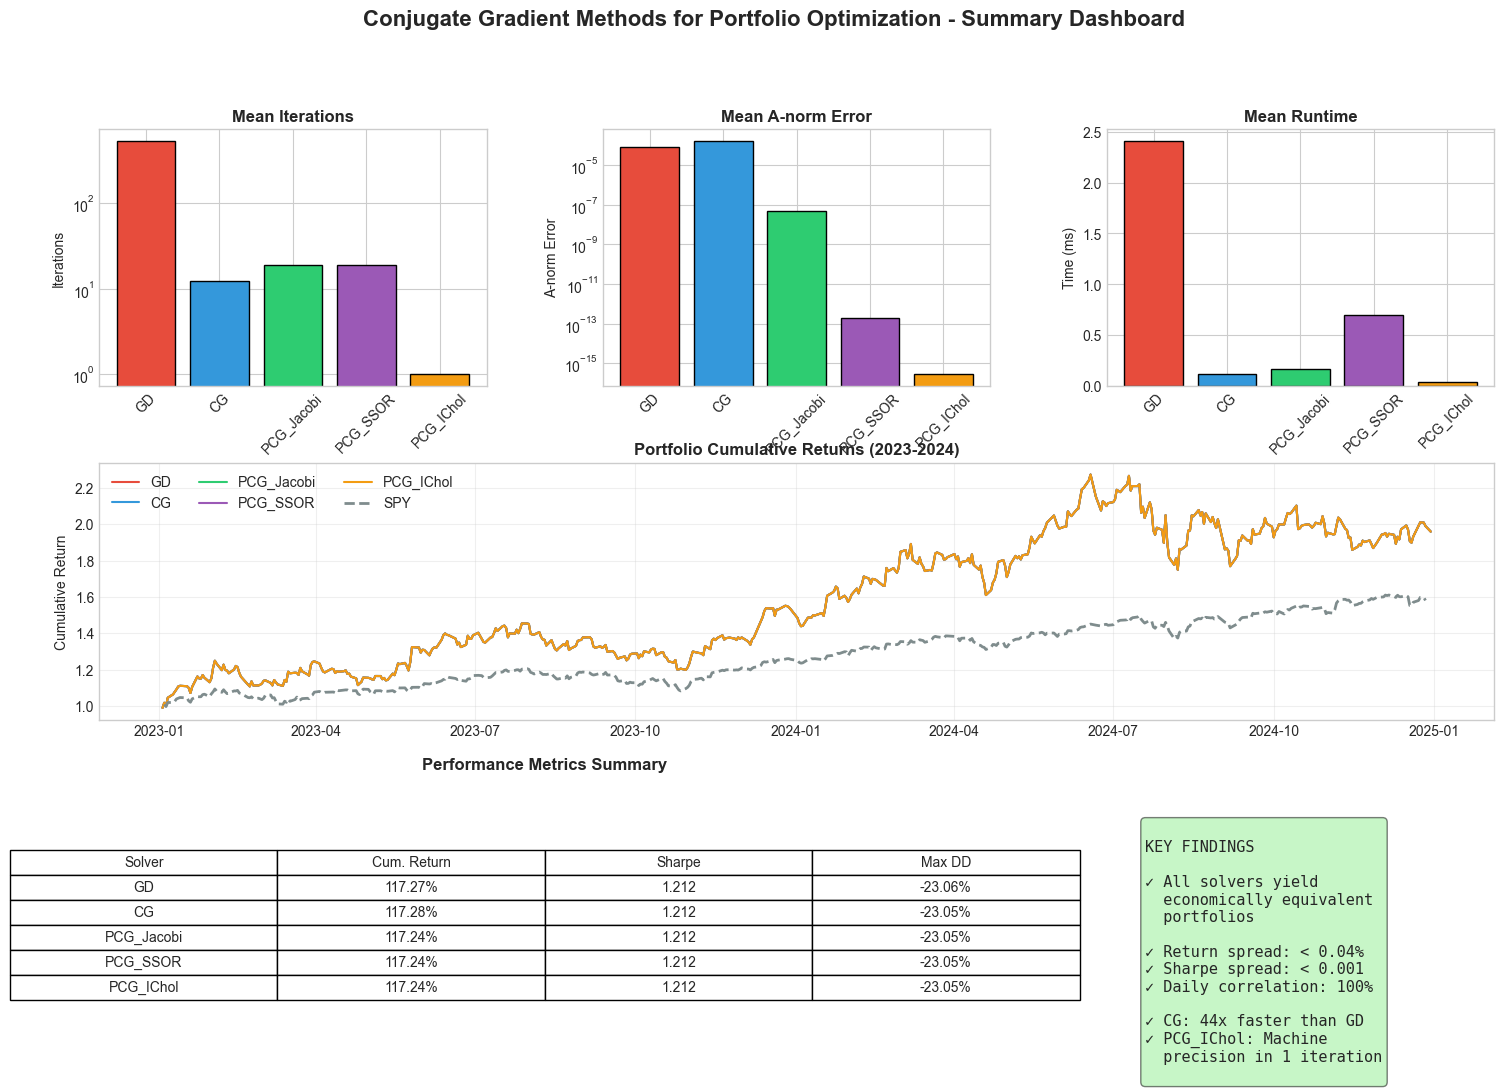

In [16]:
# 5.1 Summary Dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Iteration counts
ax1 = fig.add_subplot(gs[0, 0])
mean_iters = [diagnostics[diagnostics['solver'] == s]['iterations'].mean() for s in SOLVERS]
bars = ax1.bar(SOLVERS, mean_iters, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
ax1.set_ylabel('Iterations')
ax1.set_title('Mean Iterations', fontweight='bold')
ax1.set_yscale('log')
ax1.tick_params(axis='x', rotation=45)

# 2. A-norm error
ax2 = fig.add_subplot(gs[0, 1])
mean_errors = [diagnostics[diagnostics['solver'] == s]['a_norm_error'].mean() for s in SOLVERS]
bars = ax2.bar(SOLVERS, mean_errors, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
ax2.set_ylabel('A-norm Error')
ax2.set_title('Mean A-norm Error', fontweight='bold')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)

# 3. Runtime
ax3 = fig.add_subplot(gs[0, 2])
mean_times = [diagnostics[diagnostics['solver'] == s]['wall_clock_time_ms'].mean() for s in SOLVERS]
bars = ax3.bar(SOLVERS, mean_times, color=[SOLVER_COLORS[s] for s in SOLVERS], edgecolor='black')
ax3.set_ylabel('Time (ms)')
ax3.set_title('Mean Runtime', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# 4. Cumulative returns
ax4 = fig.add_subplot(gs[1, :])
for solver in SOLVERS:
    ax4.plot(cumulative_returns.index, cumulative_returns[solver], 
             label=solver, color=SOLVER_COLORS[solver], linewidth=1.5)
if 'SPY' in cumulative_returns.columns:
    ax4.plot(cumulative_returns.index, cumulative_returns['SPY'], 
             label='SPY', color=SOLVER_COLORS['SPY'], linewidth=2, linestyle='--')
ax4.set_ylabel('Cumulative Return')
ax4.set_title('Portfolio Cumulative Returns (2023-2024)', fontweight='bold')
ax4.legend(loc='upper left', ncol=3)
ax4.grid(True, alpha=0.3)

# 5. Performance metrics table
ax5 = fig.add_subplot(gs[2, 0:2])
ax5.axis('off')
table_data = []
for _, row in performance_metrics[performance_metrics['Solver'].isin(SOLVERS)].iterrows():
    table_data.append([row['Solver'], f"{row['Cumulative Return (%)']:.2f}%",
                       f"{row['Sharpe Ratio']:.3f}", f"{row['Max Drawdown (%)']:.2f}%"])
table = ax5.table(cellText=table_data, colLabels=['Solver', 'Cum. Return', 'Sharpe', 'Max DD'],
                  loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax5.set_title('Performance Metrics Summary', fontweight='bold', pad=20)

# 6. Key findings
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
findings_text = """
KEY FINDINGS

✓ All solvers yield
  economically equivalent
  portfolios

✓ Return spread: < 0.04%
✓ Sharpe spread: < 0.001
✓ Daily correlation: 100%

✓ CG: 44x faster than GD
✓ PCG_IChol: Machine
  precision in 1 iteration
"""
ax6.text(0.1, 0.9, findings_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.suptitle('Conjugate Gradient Methods for Portfolio Optimization - Summary Dashboard', 
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig(f'{DATA_DIR}/figures/summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()


In [17]:
# Print summary of all saved figures
print("="*60)
print("VISUALIZATION NOTEBOOK COMPLETE")
print("="*60)
print(f"\nFigures saved to: {DATA_DIR}/figures/")
print("\nGenerated visualizations:")
for f in os.listdir(f'{DATA_DIR}/figures'):
    if f.endswith('.png'):
        print(f"  - {f}")
print("\nKey Takeaway: The choice of iterative solver is a")
print("computational efficiency decision, not an economic")
print("performance decision.")


VISUALIZATION NOTEBOOK COMPLETE

Figures saved to: data/figures/

Generated visualizations:
  - price_evolution.png
  - summary_dashboard.png
  - convergence_curves.png
  - cumulative_returns.png
  - numerical_errors.png
  - iteration_convergence.png
  - correlation_analysis.png
  - risk_return_scatter.png
  - portfolio_vs_benchmark.png
  - performance_metrics.png
  - precision_efficiency.png

Key Takeaway: The choice of iterative solver is a
computational efficiency decision, not an economic
performance decision.
